In [44]:
import sys
import os

# 添加 factor_evaluation.pyd 所在的目录到系统路径
pyd_path = r"D:\MG\！internship\！4L CAPITAL\因子评估器"
sys.path.append(pyd_path)

# 导入模块
from factor_evaluation import FactorEvaluation
from factor_evaluation import DataService
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [45]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [46]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [47]:
# def adaptive_kdj_factor(df, volatility_window=20):
#     # 1. 增加价格过滤 - 避免在低波动期产生噪音
#     returns = np.log(df['close']).diff()
#     vol = returns.rolling(volatility_window, min_periods=1).std()
#     vol = np.where(np.isinf(vol), np.nan, vol)  # 替换 inf
#     vol = pd.Series(vol, index=df.index).ffill().bfill().fillna(0.01)
    
#     # 2. 优化自适应逻辑 - 引入非线性缩放
#     scaled_vol = (vol * 100).clip(5, 20)
#     # 增加对高波动市场的敏感性
#     n_period = np.where(scaled_vol > 15, 
#                         scaled_vol * 1.4, 
#                         scaled_vol * 0.6)
#     n_period = np.clip(n_period, 5, 25).astype(int)
    
#     # 3. 改进极值计算 - 增加权重衰减
#     periods = list(range(5, 26))  # 5到25
#     min_vals = []
#     max_vals = []
    
#     for p in periods:
#         # 指数衰减加权最小值
#         min_roll = df['low'].rolling(p, min_periods=1).min()
#         min_ewm = min_roll.ewm(span=max(1, p//2), adjust=False).mean()
#         min_vals.append(min_ewm)
        
#         # 指数衰减加权最大值
#         max_roll = df['high'].rolling(p, min_periods=1).max()
#         max_ewm = max_roll.ewm(span=max(1, p//2), adjust=False).mean()
#         max_vals.append(max_ewm)
    
#     min_df = pd.DataFrame(dict(zip(periods, min_vals)), index=df.index)
#     max_df = pd.DataFrame(dict(zip(periods, max_vals)), index=df.index)
    
#     # 4. 动态选择窗口
#     col_idx = (n_period - 5).clip(0, 20)
#     row_idx = np.arange(len(df))
#     low_min = min_df.values[row_idx, col_idx]
#     high_max = max_df.values[row_idx, col_idx]
    
#     # 5. 改进RSV计算 - 避免除以零
#     denom = high_max - low_min
#     # 使用 NumPy 的 where 替代 Pandas 的 replace
#     denom = np.where(denom < 1e-5, 1e-5, denom)  # 避免除以零
    
#     # 6. 改进RSV计算 - 增加平滑处理
#     rsv = 100 * (df['close'].values - low_min) / denom
#     rsv = np.clip(rsv, 0, 100)  # 限制在0-100范围内
#     rsv = pd.Series(rsv, index=df.index).fillna(50)  # 填充缺失值为50
    
#     # 7. 双EMA平滑
#     fast_k = rsv.ewm(span=2, adjust=False, min_periods=1).mean()
#     slow_k = fast_k.ewm(span=3, adjust=False, min_periods=1).mean()
    
#     # 8. 改进中心化方法 - 使用滚动中位数避免极端值影响
#     rolling_median = slow_k.rolling(100, min_periods=1).median().shift(1).fillna(50)
    
#     # 9. 最终因子构建 - 添加方向控制和归一化
#     factor = (slow_k - rolling_median)
    
#     # 10. 增加趋势强化 - 结合动量方向
#     momentum = df['close'].pct_change(3).fillna(0)
#     factor = factor * (1 + np.sign(momentum) * 0.2)
    
#     # 11. 最终归一化处理
#     abs_mean = factor.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
#     factor = factor / abs_mean
    
#     return factor

In [48]:
def trend_correlation_factor(df, window=20):
    """
    使用Pandas TA的线性回归斜率作为趋势因子
    """
    # 计算线性回归斜率
    slope = ta.linreg(df['close'], length=window, slope=True)
    return slope

In [49]:
# def rsi_factor(df, period=20):
#     # 使用Pandas TA的rsi函数
#     return ta.rsi(df['close'], length=period)

In [50]:
# def adaptive_kdj_factor_v3(df, volatility_window=20):
#     """
#     使用Pandas TA完全重构的自适应KDJ因子
#     结合波动率调整和EMA平滑
#     """
#     # 1. 计算波动率调整的周期长度
#     returns = np.log(df['close']).diff()
#     vol = returns.rolling(volatility_window, min_periods=1).std()
#     vol = vol.replace([np.inf, -np.inf], np.nan).ffill().bfill().fillna(0.01)
    
#     # 非线性缩放波动率
#     scaled_vol = (vol * 100).clip(5, 20)
#     n_period = np.where(
#         scaled_vol > 15, 
#         scaled_vol * 1.4, 
#         scaled_vol * 0.6
#     ).clip(5, 25).astype(int)
    
#     # 2. 使用Pandas TA计算自适应KDJ
#     # 为每个不同的n_period计算KDJ
#     unique_periods = np.unique(n_period)
#     kdj_results = {}
    
#     for period in unique_periods:
#         kdj = ta.kdj(df['high'], df['low'], df['close'], length=period, signal=3)
#         kdj_results[period] = kdj[f'K_{period}_3']  # 只取K值
    
#     # 3. 根据每个时间点的n_period选择对应的K值
#     k_values = pd.Series(index=df.index, dtype=float)
#     for i in range(len(df)):
#         period = n_period[i]
#         k_values.iloc[i] = kdj_results[period].iloc[i]
    
#     # 4. 中心化处理
#     rolling_median = k_values.rolling(100, min_periods=1).median().shift(1).fillna(50)
#     factor = k_values - rolling_median
    
#     # 5. 增加趋势强化
#     momentum = df['close'].pct_change(3).fillna(0)
#     factor = factor * (1 + np.sign(momentum) * 0.2)
    
#     # 6. 最终归一化
#     abs_mean = factor.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
#     return factor / abs_mean

In [51]:
def kdj_pressure_factor(df, n=9, m=3):
    # 使用Pandas TA的kdj函数
    kdj = ta.kdj(df['high'], df['low'], df['close'], length=n, signal=m)
    k = kdj[f'K_{n}_{m}']
    d = kdj[f'D_{n}_{m}']
    j = kdj[f'J_{n}_{m}']
    return (k + d + j) / 3 - 50  # 归一化压力分数

In [52]:
def j_extreme_factor(df, n=9, m=3):
    # 使用Pandas TA的kdj函数
    kdj = ta.kdj(df['high'], df['low'], df['close'], length=n, signal=m)
    j = kdj[f'J_{n}_{m}']
    # Sigmoid变换强调极端值
    return 1 / (1 + np.exp(-0.1 * (j - 50)))

In [53]:
# def macd(df, fast=12, slow=26, signal=9):
#     # 使用Pandas TA的macd函数
#     macd_result = ta.macd(df['close'], fast=fast, slow=slow, signal=signal)
#     return macd_result['MACD_12_26_9'].fillna(0)  # 返回MACD线

In [54]:
def atr(df, period=14):
    # 使用Pandas TA的atr函数
    return ta.atr(df['high'], df['low'], df['close'], length=period).fillna(0)

In [55]:
def optimize_weights(df, factors, target):
    # Create feature matrix X from factors
    X = pd.DataFrame({name: factor(df) for name, factor in factors.items()})
    y = target(df)
    # Remove rows with NaN in X or y
    valid_rows = X.notna().all(axis=1) & y.notna()
    X = X.loc[valid_rows]
    y = y.loc[valid_rows]
    # Check if there's enough data to fit the model
    if len(X) == 0:
        raise ValueError("No valid data remaining after removing NaN values.")
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_

In [56]:
def improved_factor(df):
    # 使用Pandas TA计算所有因子
    # adaptive_kdj = adaptive_kdj_factor(df)
    buy_pressure = df['taker_buy_turnover'] / df['turnover'].replace(0, np.nan).fillna(0)
    # macd_diff = macd(df)  # 使用Pandas TA版本
    atr_value = atr(df)  # 使用Pandas TA版本
    
    # 使用Pandas TA计算其他因子
    trend_corr = trend_correlation_factor(df)
    # rsi = rsi_factor(df)  # 使用Pandas TA版本
    # adaptive_kdj_v3 = adaptive_kdj_factor_v3(df)
    kdj_pressure = kdj_pressure_factor(df)  # 使用Pandas TA版本
    j_extreme = j_extreme_factor(df)  # 使用Pandas TA版本
    
    # 标准化所有因子
    factors_to_standardize = {
        # 'adaptive_kdj': adaptive_kdj,
        'buy_pressure': buy_pressure,
        # 'macd_diff': macd_diff,
        'atr': atr_value,
        'trend_corr': trend_corr,
        # 'rsi': rsi,
        # 'adaptive_kdj_v3': adaptive_kdj_v3,
        'kdj_pressure': kdj_pressure,
        'j_extreme': j_extreme
    }
    
    # ... [标准化和组合因子的代码保持不变] ...
    
    standardized_factors = {}
    for name, factor_series in factors_to_standardize.items():
        # 处理特殊情况：j_extreme因子范围在0-1之间，需要特殊处理
        if name == 'j_extreme':
            # 将0-1范围映射到-1到1范围
            factor_series = 2 * (factor_series - 0.5)
        
        # 标准化处理
        mean_val = factor_series.mean()
        std_val = factor_series.std()
        if std_val < 1e-5:
            standardized_factor = factor_series - mean_val
        else:
            standardized_factor = (factor_series - mean_val) / std_val
        
        # 填充NaN为0
        standardized_factors[name] = standardized_factor.fillna(0)
    
    # 4. 定义因子字典和目标函数
    factors = {
        # 'adaptive_kdj': lambda df: standardized_factors['adaptive_kdj'],
        'buy_pressure': lambda df: standardized_factors['buy_pressure'],
        # 'macd_diff': lambda df: standardized_factors['macd_diff'],
        'atr': lambda df: -standardized_factors['atr'],  # 负ATR惩罚高波动性
        'trend_corr': lambda df: standardized_factors['trend_corr'],
        # 'rsi': lambda df: standardized_factors['rsi'],
        # 'adaptive_kdj_v3': lambda df: standardized_factors['adaptive_kdj_v3'],
        'kdj_pressure': lambda df: standardized_factors['kdj_pressure'],
        'j_extreme': lambda df: standardized_factors['j_extreme']
    }
    
    # 目标函数：未来10期收益率
    target = lambda df: df['close'].pct_change(10).shift(-10)
    
    # 5. 优化权重
    weights = optimize_weights(df, factors, target)
    
    # 6. 组合因子
    combined_factor = sum(weight * factor(df) for weight, factor in zip(weights, factors.values()))
    
    # 7. 最终归一化处理
    abs_mean = combined_factor.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
    normalized_factor = combined_factor / abs_mean
    
    return normalized_factor

In [57]:
# 在evaluator中使用新版因子
evaluator.set_factor(
    factor_data_or_func=improved_factor,
    factor_name='improved_factor_with_ta'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.008753
   Rank_IC (Spearman): -0.002152
📊 信息比率:
   IR: 0.405243
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130650
   因子列: improved_factor_with_ta
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


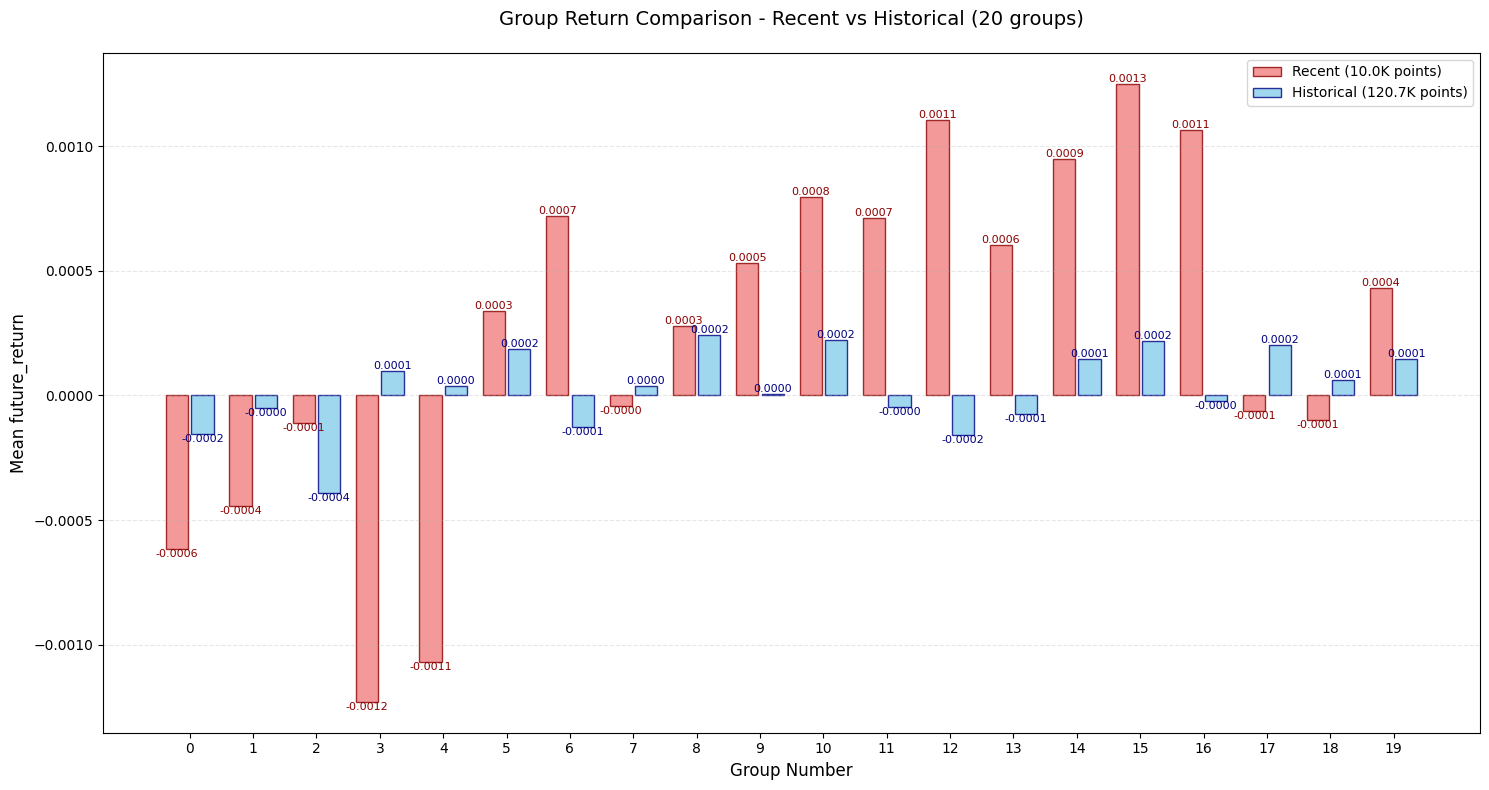

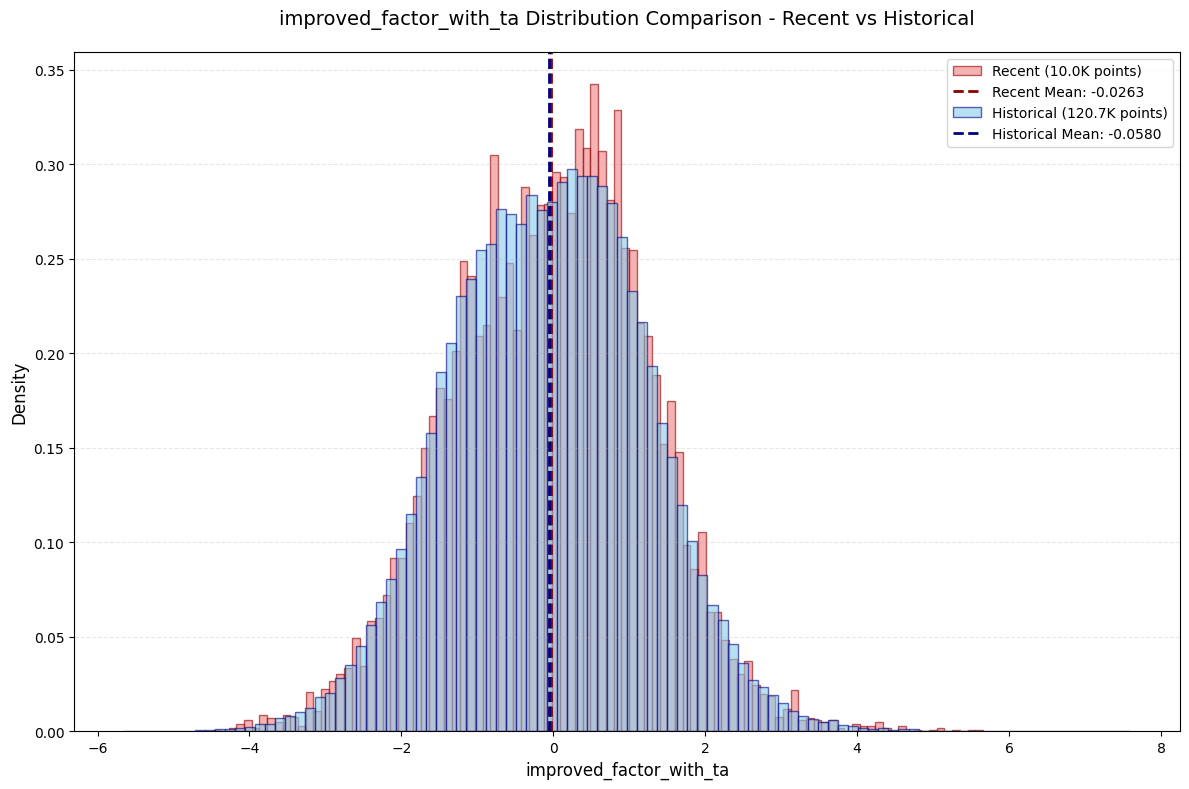

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [58]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)